### Импорты

In [3]:
import numpy as np
import pandas as pd

In [4]:
from simpledbf import Dbf5

SQLalchemy is not installed. No support for SQL output.


In [5]:
import matplotlib.pyplot as plt

In [49]:
from sklearn.neural_network import MLPRegressor

In [59]:
from sklearn.metrics import mean_squared_error

### Загрузка из dbf (файлы баз данных)

загружаем данные из файлов формата `dbf`  с использованием библиотеки `simpledbf`

In [6]:
sales = Dbf5('sales.dbf', codec='cp1251')

конвертируем в нативную для `Pandas` форму датафрейма `df`

In [7]:
sales_df = sales.to_dataframe()

In [90]:
test = pd.read_csv('fact.txt', sep='\t', encoding='cp1251')

In [10]:
sales_df.head(10)

,DATA,TOVAR,KOL,SUMMA
0,2001-06-19,00092860,1.0,387.20
1,2001-06-19,00092861,8.0,774.40
2,2001-06-19,00092864,2.0,431.24
3,2001-06-19,00092867,1.0,316.80
4,2001-06-19,00092869,1.0,264.00
5,2001-06-19,00092873,2.0,739.20
6,2001-06-19,00092881,1.0,378.42
7,2001-06-20,00092865,2.0,431.20
8,2001-06-21,00092861,4.0,387.27
9,2001-06-21,00092864,2.0,431.20


In [11]:
sales_df.TOVAR.nunique()

189

In [12]:
sales_df.DATA.nunique()

903

In [13]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8955 entries, 0 to 8954
Data columns (total 4 columns):
DATA     8955 non-null object
TOVAR    8955 non-null object
KOL      8955 non-null float64
SUMMA    8955 non-null float64
dtypes: float64(2), object(2)
memory usage: 279.9+ KB


### Предварительная обработка 

In [14]:
# Переведем колонку `DATA`  в формат datetime
sales_df.DATA = pd.to_datetime(sales_df.DATA, yearfirst=True)

In [15]:
print(sales_df.DATA.min())
print(sales_df.DATA.max())

2001-06-19 00:00:00
2004-10-31 00:00:00


In [16]:
# Назначим даты индексом в DataFrame
sales_df.set_index('DATA', inplace=True)

In [17]:
# Отсортируем индекс по возрастанию
sales_df.sort_index(inplace=True)

In [18]:
sales_df.index = sales_df.index.to_period(freq='D')

In [19]:
sales_df.head(10)

,TOVAR,KOL,SUMMA
DATA,,,
2001-06-19,00092860,1.0,387.20
2001-06-19,00092861,8.0,774.40
2001-06-19,00092864,2.0,431.24
2001-06-19,00092867,1.0,316.80
2001-06-19,00092869,1.0,264.00
2001-06-19,00092873,2.0,739.20
2001-06-19,00092881,1.0,378.42
2001-06-20,00092865,2.0,431.20
2001-06-21,00092861,4.0,387.27


In [20]:
sales_df.drop('TOVAR', axis=1, inplace=True)

In [21]:
# сгруппируем данные по месяцам продаж, агрегация по сумме
sales_by_month = sales_df.resample('M').sum()

In [22]:
sales_by_month.head(10)

,KOL,SUMMA
DATA,,
2001-06,163.0,23584.34
2001-07,182.0,26192.45
2001-08,209.0,36497.35
2001-09,147.0,25624.92
2001-10,217.0,40886.54
2001-11,724.0,107230.90
2001-12,741.0,106877.63
2002-01,547.0,78972.99
2002-02,702.0,109098.54


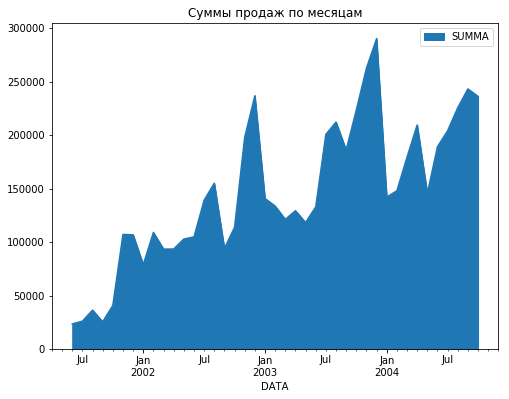

In [23]:
sales_by_month[['SUMMA']].plot(kind='area', figsize=(8,6), title='Суммы продаж по месяцам');

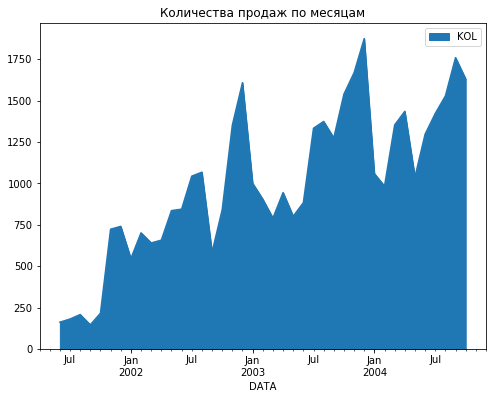

In [24]:
sales_by_month[['KOL']].plot(kind='area', figsize=(8,6), title='Количества продаж по месяцам');

#### Тест 

In [91]:
test.columns = ['DATA', 'SUMMA', 'KOL']

In [92]:
test['DATA'] = pd.to_datetime(test.DATA, format='%m.%Y')

In [93]:
test.set_index('DATA', inplace=True)

In [95]:
test.index = test.index.to_period('M')

In [97]:
test

,SUMMA,KOL
DATA,,
2004-11,268384.0,1890
2004-12,396718.1,2792


In [101]:
sales_w_test = pd.concat([sales_by_month, test], sort=True, axis=0)

###  Поиск корреляции между лагами и автокорреляции

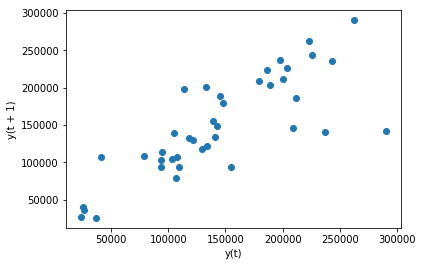

In [25]:
# Lag-plots для выявления корреляции между значением сумм на
# отрезке времени t+1 от сумм на отрезке времени t 
pd.plotting.lag_plot(sales_by_month.SUMMA);

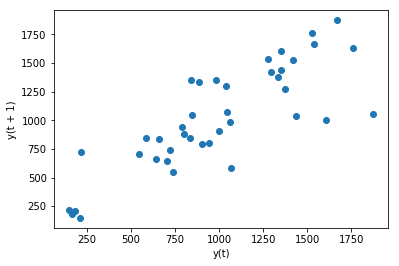

In [26]:
pd.plotting.lag_plot(sales_by_month.KOL);

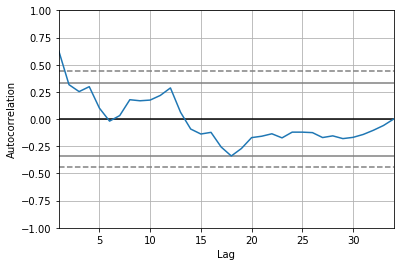

In [27]:
pd.plotting.autocorrelation_plot(sales_by_month.truncate(before='2002').SUMMA);

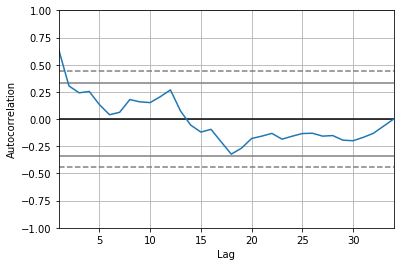

In [28]:
pd.plotting.autocorrelation_plot(sales_by_month.truncate(before='2002').KOL);

#### Скользящее окно 

In [29]:
sales_by_day = (sales_df.resample('D')
                .sum()
                .sort_index())

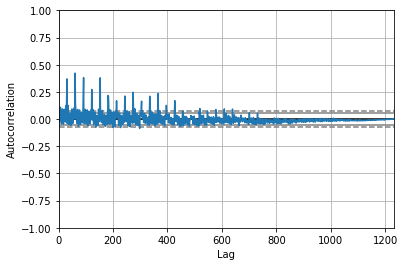

In [30]:
pd.plotting.autocorrelation_plot(sales_by_day.SUMMA)

In [31]:
rw = sales_by_day.rolling(window=30)

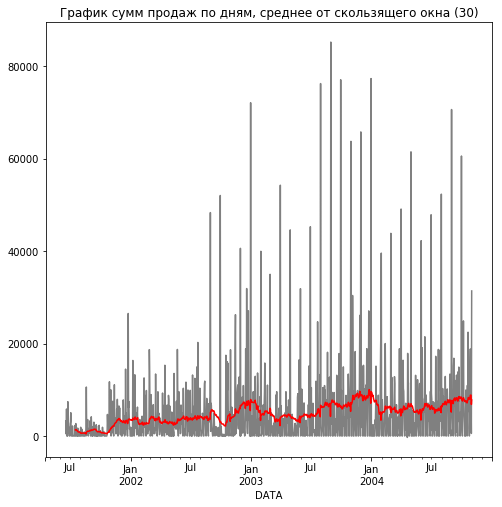

In [32]:
sales_by_day.SUMMA.plot(color='gray', figsize=(8,8), title='График сумм продаж по дням, среднее от скользящего окна (30)');
rw.mean()['SUMMA'].plot(color='red');

In [33]:
rw = sales_by_month.rolling(window=6)

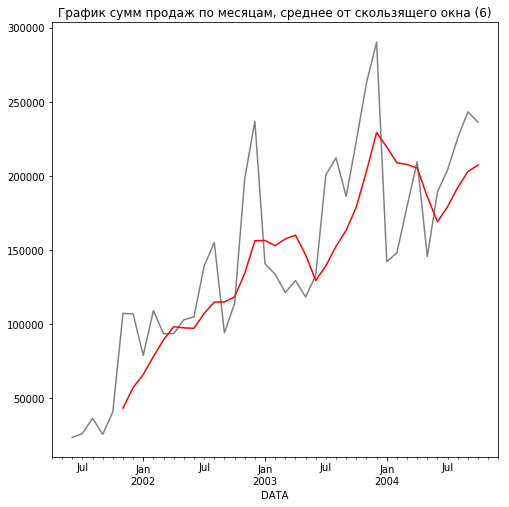

In [34]:
sales_by_month.SUMMA.plot(color='gray', figsize=(8,8), title='График сумм продаж по месяцам, среднее от скользящего окна (6)');
rw.mean()['SUMMA'].plot(color='red');

### Подготовка данных для обучения нейросети - эксперимент 1

In [102]:
# сдвигаем значения на i в прошлое и формируем имена для колонок
shifts = []
names = []
for i in (1,2,3,12):
    names.extend([f'KOL_{i}', f'SUMMA_{i}'])
    shifts.append(sales_w_test.shift(i))

In [103]:
# создаем DataFrame с последовательностью из записей 1,2,3,12 месяцев назад
shifted_df = pd.concat(shifts, axis=1)

In [104]:
# даем понятные имена
shifted_df.columns = names

In [105]:
# для того, чтобы не терять примеров в выборке
# заменим пропуски на медианные значения
shifted_df.fillna(shifted_df.median(), inplace=True)

In [107]:
shifted_df.tail(10)

,KOL_1,SUMMA_1,KOL_2,SUMMA_2,KOL_3,SUMMA_3,KOL_12,SUMMA_12
DATA,,,,,,,,
2004-03,984.0,148030.61,1059.0,142150.37,1874.0,290191.42,791.0,121297.04
2004-04,1353.0,179439.95,984.0,148030.61,1059.0,142150.37,945.0,129349.33
2004-05,1435.0,209491.60,1353.0,179439.95,984.0,148030.61,802.0,118342.87
2004-06,1039.0,145582.17,1435.0,209491.60,1353.0,179439.95,884.0,132945.89
2004-07,1297.0,189178.99,1039.0,145582.17,1435.0,209491.60,1333.0,200744.99
2004-08,1422.0,204073.75,1297.0,189178.99,1039.0,145582.17,1374.0,212183.74
2004-09,1528.0,225672.45,1422.0,204073.75,1297.0,189178.99,1275.0,186138.13
2004-10,1759.0,243166.63,1528.0,225672.45,1422.0,204073.75,1539.0,223449.01
2004-11,1630.0,236117.68,1759.0,243166.63,1528.0,225672.45,1668.0,262605.30


In [109]:
all(sales_w_test.index == shifted_df.index)

True

In [123]:
# Разделим выборку на тренировочный, валидационный и тестовый набор
# для валидации возьмем последние 4 месяца
def valid_split(df, n_trn):
    return df[:n_trn].copy(), df[n_trn:].copy()

In [138]:
n_test = 2
n_trn = len(shifted_df) - n_test

In [139]:
X_train, X_test = valid_split(shifted_df, n_trn)
Y_train, Y_test = valid_split(sales_w_test, n_trn)

In [140]:
# разделим оставшиеся тренировочные данные на трейн и валидацию
n_val = 4
n_trn = len(X_train) - n_val

X_train, X_valid = valid_split(X_train, n_trn)
Y_train, Y_valid = valid_split(Y_train, n_trn)

In [141]:
X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape

((37, 8), (4, 8), (2, 8), (37, 2), (4, 2), (2, 2))

#### Обучение и валидация нейросети - эксп. 1

In [142]:
nnr = MLPRegressor(hidden_layer_sizes=(4,), verbose=True, max_iter=1000)

In [143]:
nnr.fit(X_train, Y_train)

Iteration 1, loss = 6113340050.77819061
Iteration 2, loss = 6098421124.66602993
Iteration 3, loss = 6083672605.84537601
Iteration 4, loss = 6069096519.13320827
Iteration 5, loss = 6054694721.74951744
Iteration 6, loss = 6040468894.59548569
Iteration 7, loss = 6026420534.27471256
Iteration 8, loss = 6013206626.92212486
Iteration 9, loss = 6000486690.32356739
Iteration 10, loss = 5988207715.49117851
Iteration 11, loss = 5977308347.82321167
Iteration 12, loss = 5966639731.06394100
Iteration 13, loss = 5956185324.88473034
Iteration 14, loss = 5945932207.56991863
Iteration 15, loss = 5935870056.60489559
Iteration 16, loss = 5925990453.87803078
Iteration 17, loss = 5916478314.44491768
Iteration 18, loss = 5907442431.04094219
Iteration 19, loss = 5898591009.90884781
Iteration 20, loss = 5889916169.72665310
Iteration 21, loss = 5881410995.22764683
Iteration 22, loss = 5873070547.74172974
Iteration 23, loss = 5864905379.03638458
Iteration 24, loss = 5856902936.71877480
Iteration 25, loss = 5849

Iteration 345, loss = 1125120746.21652699
Iteration 346, loss = 1111852937.02150083
Iteration 347, loss = 1098787158.04928493
Iteration 348, loss = 1085922351.51436257
Iteration 349, loss = 1073257418.72297812
Iteration 350, loss = 1060791220.92182326
Iteration 351, loss = 1048522580.15985727
Iteration 352, loss = 1036450280.16280425
Iteration 353, loss = 1024573067.22044873
Iteration 354, loss = 1012889651.08631873
Iteration 355, loss = 1001398705.88876593
Iteration 356, loss = 990098871.05277789
Iteration 357, loss = 978988752.23241258
Iteration 358, loss = 968066922.25348997
Iteration 359, loss = 957331922.06566024
Iteration 360, loss = 946782261.70312309
Iteration 361, loss = 936416421.25363672
Iteration 362, loss = 926232851.83537233
Iteration 363, loss = 916229976.58075702
Iteration 364, loss = 906406191.62652683
Iteration 365, loss = 896759867.10953641
Iteration 366, loss = 887289348.16778994
Iteration 367, loss = 877992955.94590449
Iteration 368, loss = 868868988.60421646
Itera

Iteration 665, loss = 494044282.44619882
Iteration 666, loss = 494004537.83381104
Iteration 667, loss = 493964777.79407334
Iteration 668, loss = 493925002.22350675
Iteration 669, loss = 493885211.02695674
Iteration 670, loss = 493845404.11717284
Iteration 671, loss = 493805581.41440666
Iteration 672, loss = 493765742.84602994
Iteration 673, loss = 493725888.34617138
Iteration 674, loss = 493686017.85537130
Iteration 675, loss = 493646131.32025313
Iteration 676, loss = 493606228.69321048
Iteration 677, loss = 493566309.93211108
Iteration 678, loss = 493526375.00001401
Iteration 679, loss = 493486423.86490083
Iteration 680, loss = 493446456.49942058
Iteration 681, loss = 493406472.88064885
Iteration 682, loss = 493366472.98985457
Iteration 683, loss = 493326456.81228352
Iteration 684, loss = 493286424.33694881
Iteration 685, loss = 493246375.55643475
Iteration 686, loss = 493206310.46670789
Iteration 687, loss = 493166229.06693929
Iteration 688, loss = 493126131.35933512
Iteration 689, l

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [144]:
preds = nnr.predict(X_valid)

In [145]:
preds

array([[  1429.10532205, 208179.94385187],
       [  1303.41983787, 189861.96361633],
       [  1471.29616316, 214329.03098509],
       [  1605.00710019, 233816.67761195]])

In [146]:
Y_valid

,KOL,SUMMA
DATA,,
2004-07,1422.0,204073.75
2004-08,1528.0,225672.45
2004-09,1759.0,243166.63
2004-10,1630.0,236117.68


In [147]:
# корень средне-квадратичной ошибки по количеству
np.sqrt(mean_squared_error(Y_valid.KOL, preds[:,0]))

182.9514126747553

In [148]:
# корень средне-квадратичной ошибки по сумме
np.sqrt(mean_squared_error(Y_valid.SUMMA, preds[:,1]))

23109.270282283313

In [149]:
test_preds = nnr.predict(X_test)

In [150]:
test_preds

array([[  1661.6515977 , 242072.3070711 ],
       [  1870.30235231, 272482.02720865]])

In [151]:
Y_test

,KOL,SUMMA
DATA,,
2004-11,1890.0,268384.0
2004-12,2792.0,396718.1


In [152]:
# корень средне-квадратичной ошибки по количеству
np.sqrt(mean_squared_error(Y_test.KOL, test_preds[:,0]))

671.4423082387848

In [153]:
# корень средне-квадратичной ошибки по сумме
np.sqrt(mean_squared_error(Y_test.SUMMA, test_preds[:,1]))

89796.73425966356

### Подготовка данных для обучения нейросети  - эксперимент 2

В этом эксперименте удалим все примеры с неполными данными

In [177]:
# сдвигаем значения на i в прошлое и формируем имена для колонок
shifts = []
names = []
for i in (1,2,3,12):
    names.extend([f'KOL_{i}', f'SUMMA_{i}'])
    shifts.append(sales_w_test.shift(i))

In [178]:
# создаем DataFrame с последовательностью из записей 1,2,3,12 месяцев назад
shifted_df = pd.concat(shifts, axis=1)

In [179]:
# даем понятные имена
shifted_df.columns = names

In [157]:
# для того, чтобы не терять примеров в выборке
# заменим пропуски на медианные значения
shifted_df.fillna(shifted_df.median(), inplace=True)

In [193]:
shifted_df = shifted_df.truncate(before='2002-06')

In [194]:
shifted_df.head()

,KOL_1,SUMMA_1,KOL_2,SUMMA_2,KOL_3,SUMMA_3,KOL_12,SUMMA_12
DATA,,,,,,,,
2002-06,836.0,102910.35,658.0,93587.80,641.0,93518.36,163.0,23584.34
2002-07,845.0,104904.28,836.0,102910.35,658.0,93587.80,182.0,26192.45
2002-08,1044.0,139225.67,845.0,104904.28,836.0,102910.35,209.0,36497.35
2002-09,1068.0,155069.09,1044.0,139225.67,845.0,104904.28,147.0,25624.92
2002-10,585.0,94088.40,1068.0,155069.09,1044.0,139225.67,217.0,40886.54


In [196]:
sales_w_test = sales_w_test.truncate(before='2002-06')

In [197]:
sales_w_test.head()

,KOL,SUMMA
DATA,,
2002-06,845.0,104904.28
2002-07,1044.0,139225.67
2002-08,1068.0,155069.09
2002-09,585.0,94088.40
2002-10,841.0,113904.12


In [198]:
all(sales_w_test.index == shifted_df.index)

True

In [199]:
# Разделим выборку на тренировочный, валидационный и тестовый набор
# для валидации возьмем последние 4 месяца
def valid_split(df, n_trn):
    return df[:n_trn].copy(), df[n_trn:].copy()

In [200]:
n_test = 2
n_trn = len(shifted_df) - n_test

In [201]:
X_train, X_test = valid_split(shifted_df, n_trn)
Y_train, Y_test = valid_split(sales_w_test, n_trn)

In [202]:
# разделим оставшиеся тренировочные данные на трейн и валидацию
n_val = 4
n_trn = len(X_train) - n_val

X_train, X_valid = valid_split(X_train, n_trn)
Y_train, Y_valid = valid_split(Y_train, n_trn)

In [203]:
X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape

((25, 8), (4, 8), (2, 8), (25, 2), (4, 2), (2, 2))

#### Обучение и валидация нейросети - эксп.2

In [258]:
nnr = MLPRegressor(hidden_layer_sizes=(4,), learning_rate_init=0.001, max_iter=10000)

In [259]:
nnr.fit(X_train, Y_train)

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [260]:
preds = nnr.predict(X_valid)

In [261]:
preds

array([[  1717.8787178 , 252873.82133098],
       [  1684.26363803, 247924.94346907],
       [  1692.65417072, 249160.21411998],
       [  1920.73206773, 282738.28869001]])

In [262]:
Y_valid

,KOL,SUMMA
DATA,,
2004-07,1422.0,204073.75
2004-08,1528.0,225672.45
2004-09,1759.0,243166.63
2004-10,1630.0,236117.68


In [263]:
# корень средне-квадратичной ошибки по количеству
np.sqrt(mean_squared_error(Y_valid.KOL, preds[:,0]))

224.10346075439824

In [264]:
# корень средне-квадратичной ошибки по сумме
np.sqrt(mean_squared_error(Y_valid.SUMMA, preds[:,1]))

35658.18500965113

In [265]:
test_preds = nnr.predict(X_test)

In [266]:
test_preds

array([[  2058.05291387, 302954.93253126],
       [  2354.63804873, 346618.77679404]])

In [267]:
Y_test

,KOL,SUMMA
DATA,,
2004-11,1890.0,268384.0
2004-12,2792.0,396718.1


In [268]:
# корень средне-квадратичной ошибки по количеству
np.sqrt(mean_squared_error(Y_test.KOL, test_preds[:,0]))

331.3059449184836

In [269]:
# корень средне-квадратичной ошибки по сумме
np.sqrt(mean_squared_error(Y_test.SUMMA, test_preds[:,1]))

43041.21026281641